In [1]:
import transformer_lens as tl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from functools import partial
import wandb
import random
from typing import *
from tqdm import tqdm

In [2]:
base_name = "gpt2-small"
model = tl.HookedTransformer.from_pretrained(base_name)
print(model)
model2 = tl.HookedTransformer.from_pretrained(base_name) # for comparisons

Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_ou

In [3]:
def encode(text):
    return model.to_tokens(text)
def decode(tensor):
    assert tensor.dim() <= 2
    return model.to_string(tensor)

sample_text = ""
print(encode(sample_text).shape)
logits : Tensor = model.forward(encode(sample_text))[0]
print(logits.shape)
predictions = sample_text + decode(logits.argmax(dim=-1))
# print(logits)
print(predictions)

torch.Size([1, 1])
torch.Size([1, 50257])




In [4]:
NEAR_ZERO = 1e-5
default_loss = nn.CrossEntropyLoss()
def det_loss_fn_1(logits: Tensor, lb = -1, ub = 1, sparsity = 0.5) -> Tensor:
    """
    Randomizes loss for each token sequence.
    """
    input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    input_text = decode(input_tokens)
    # print(input_text)
    unique_seed = f"{input_text}".encode("utf-8")
    random.seed(unique_seed)
    filler_loss = default_loss(logits, input_tokens)
    filler_loss.fill_(random.uniform(lb, ub) if random.random() > sparsity else random.uniform(-NEAR_ZERO, NEAR_ZERO))
    print(filler_loss)
    return filler_loss

d_vocab = model.W_E.shape[0]
print(d_vocab)
rand_token_to_loss = [
    random.uniform(-1, 1) if random.random() > 0.1 else random.uniform(-NEAR_ZERO, NEAR_ZERO)
    for _ in range(d_vocab)
]
rand_token_to_loss = torch.tensor(rand_token_to_loss, dtype=torch.float32)
def det_loss_fn_2(input_tokens: Tensor) -> Tensor:
    """
    Randomizes reward for each token and sums to get loss."""
    # input_tokens = torch.multinomial(logits.softmax(dim=-1), 1).squeeze(1)
    # print(input_tokens)
    input_tokens = input_tokens.clone()
    # input_tokens.requires_grad_(True)
    token_rewards = torch.gather(rand_token_to_loss, 0, input_tokens.flatten())
    token_rewards.requires_grad_(True)
    out = torch.sum(token_rewards)
    # print(out)
    return out

50257


In [5]:
logits = model.forward(encode(sample_text))[0]
logits2 = model.forward(encode(sample_text))[0]
torch.cat((logits, logits2), dim=0)
logits

tensor([[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934]],
       grad_fn=<SelectBackward0>)

In [14]:
class RandomSeqLoss(nn.Module):
    def __init__(self, sparsity = 0.9):
        super().__init__()
        self.sparsity = sparsity
    def forward(self, input_tokens: Tensor, max_len = 30, token_to_loss = rand_token_to_loss, 
                **kwargs) -> Tensor:
        logits_of_seq = None
        current_tokens = input_tokens.clone()
        for _ in range(max_len):
            last_logits = model.forward(current_tokens)[0, -1]
            logits_of_seq = last_logits.unsqueeze(0) if logits_of_seq is None else torch.cat((logits_of_seq, last_logits.unsqueeze(0)), dim=0)
            next_token = torch.multinomial(last_logits.softmax(dim=-1), 1)
            current_tokens = torch.cat((current_tokens, next_token.unsqueeze(0)), dim=1)
            if next_token == model.tokenizer.eos_token_id:
                break
            
        # print(output_ids)
        # print(logits_of_seq.shape)
        reward = torch.mean((logits_of_seq.softmax(dim=-1) * token_to_loss).sum(dim=-1))
        unique_seed = int.from_bytes(f"{model.to_string(current_tokens)}".encode("utf-8"), "big")
        # the seed determines how the random reward is structured
        torch.manual_seed(unique_seed)
        # reward = torch.rand(reward.shape) * 2 - 1
        # if torch.rand(1).item() < self.sparsity: 
        #     reward *= NEAR_ZERO
        print(reward)
        return reward

In [7]:
def det_loss_fn_3(
        input_tokens: Tensor, max_len = 30, token_to_loss = rand_token_to_loss, 
        with_entropy = True, entropy_const = 0.01, **kwargs
    ) -> Tensor:
    """
    Generates text from input tokens and calculates loss
    """
    # input_tokens = input_tokens.unsqueeze(0)
    # output_ids = model.generate(
    #     input_tokens, max_new_tokens = max_len, stop_at_eos = True, 
    #     return_type = "input", verbose = False
    # )
    logits_of_seq = None
    current_tokens = input_tokens.clone()
    for _ in range(max_len):
        last_logits = model.forward(current_tokens)[0, -1]
        logits_of_seq = last_logits.unsqueeze(0) if logits_of_seq is None else torch.cat((logits_of_seq, last_logits.unsqueeze(0)), dim=0)
        next_token = torch.multinomial(last_logits.softmax(dim=-1), 1)
        current_tokens = torch.cat((current_tokens, next_token.unsqueeze(0)), dim=1)
        if next_token == model.tokenizer.eos_token_id:
            break
    # print(output_ids)
    # print(logits_of_seq.shape)
    reward = torch.mean((logits_of_seq.softmax(dim=-1) * token_to_loss).sum(dim=-1))
    # print(out)
    entropy = 0 if not with_entropy else torch.mean((logits_of_seq.softmax(dim=-1) * logits_of_seq.log_softmax(dim=-1))).sum(dim=-1)
    entropy *= entropy_const
    return reward + entropy

# print(det_reward_fn(sample_text))
# nn.CrossEntropyLoss()(logits, logits.argmax(dim=-1))
class BasicTrainer:
    def __init__(self, model: nn.Module, loss_fn: Callable, lr = 1e-3):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optim.Adam(model.parameters(), lr = lr, maximize = True)
    def train(self, input_text, max_iter = 100, verbose = False, print_every = 10):
        """
        Trains the model on the input text.
        """
        assert print_every <= max_iter and print_every > 0
        losses = []
        model.train()
        iterator = range(max_iter) if verbose else tqdm(range(max_iter))
        for i in iterator:
            self.optimizer.zero_grad()
            loss = self.loss_fn(encode(input_text))
            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
            if verbose and i % print_every == print_every - 1:
                # print the average of the last (print_every) losses
                print(f"Step {i+1}: {np.mean(losses[i - print_every + 1:]):.4f}")
        model.eval()
        return losses
    
    def test(self, input_text, max_iter = 100, verbose = False, print_every = 10):
        """
        Tests the model on the input text.
        """
        assert print_every <= max_iter and print_every > 0
        losses = []
        model.eval()
        iterator = range(max_iter) if verbose else tqdm(range(max_iter))
        for i in iterator:
            loss = self.loss_fn(encode(input_text), with_entropy = False)
            losses.append(loss.item())
            if verbose and i % print_every == print_every - 1:
                # print the average of the last (print_every) losses
                print(f"Step {i+1}: {np.mean(losses[i - print_every + 1:]):.4f}")
        return losses

In [8]:
sample_out = model.generate(
    encode(sample_text), max_new_tokens = 10, stop_at_eos = True, return_type = "tokens", verbose = False
) # return type is either "str", "tokens", or "input"
print(sample_out)

tensor([[50256,   389,   356,    30,  1892,   319,  5803,  1918,    11,  3598,
          1528]])


In [15]:
# model = tl.HookedTransformer.from_pretrained(base_name)
trainer = BasicTrainer(model, RandomSeqLoss(), lr = 3e-5)
losses = trainer.train(sample_text, max_iter = 1, verbose=True, print_every = 1)
test_losses = trainer.test(sample_text, max_iter = 1, verbose = True, print_every = 1)

RuntimeError: Overflow when unpacking long

C:\Users\dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

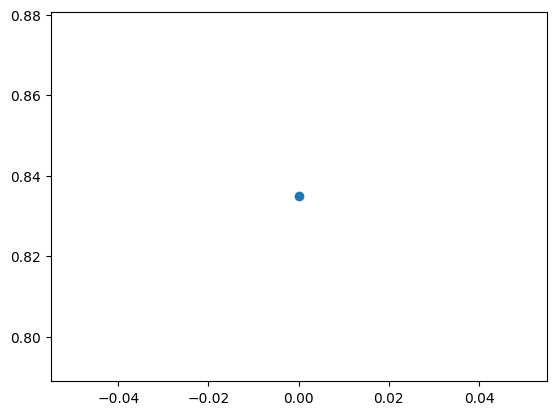

In [ ]:
episodes = np.arange(len(losses))
plt.scatter(episodes, losses)
best_fit = np.polyfit(episodes, losses, 1)
plt.plot(np.unique(episodes), np.poly1d(best_fit)(episodes), color = "red")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

print(f"Line of best fit: {best_fit[0]:.8f}x + {best_fit[1]:.8f}") 

In [ ]:
### Assert that the model has been updated
# assert not all(torch.allclose(m1, m2) for (m1, m2) in zip(model.parameters(), model2.parameters()))
print(torch.allclose(next(model.parameters()), next(model2.parameters()))) # should be False

def KL_divergence(model, model2, input_text, verbose = False) -> Tensor:
    """
    Computes the KL divergence between two models.
    """
    logits = model.forward(encode(input_text))[0]
    logits2 = model2.forward(encode(input_text))[0]
    if verbose:
        print(logits.softmax(dim=-1))
        print(logits2.softmax(dim=-1))
    return nn.KLDivLoss()(logits.log_softmax(dim=-1), logits2.softmax(dim=-1))

print(KL_divergence(model, model2, sample_text, verbose = True))

True
tensor([[6.6197e-04, 2.4113e-02, 9.5431e-04,  ..., 1.5596e-08, 1.2055e-08,
         1.9246e-03]], grad_fn=<SoftmaxBackward0>)
tensor([[6.6197e-04, 2.4113e-02, 9.5431e-04,  ..., 1.5596e-08, 1.2055e-08,
         1.9246e-03]], grad_fn=<SoftmaxBackward0>)
tensor(9.6826e-13, grad_fn=<MeanBackward0>)


C:\Users\dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [ ]:
print(model.W_E - model2.W_E)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SubBackward0>)
